<center><img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="100"><br/>
This starter notebook is provided by the Keras team.</center>

# BirdCLEF 2024 with [KerasCV](https://github.com/keras-team/keras-cv) and [Keras](https://github.com/keras-team/keras)

This notebook is built on top of Keras starter notebook. It uses VGGish to directly embed raw audio (.ogg files) instead of spectrogram for training.


# Import Libraries 📚

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # "jax" or "tensorflow" or "torch" 

import keras
import keras.backend as K
import tensorflow as tf
import tensorflow_io as tfio

import numpy as np 
import pandas as pd
import soundfile as sf
from glob import glob
from tqdm import tqdm

import librosa
import IPython.display as ipd
import librosa.display as lid

import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = mpl.cm.get_cmap('coolwarm')

2024-11-11 11:06:09.799278: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-11 11:06:09.809393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731341169.819900   11457 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731341169.822752   11457 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 11:06:09.835780: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Library Version

In [2]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("TensorFlow-IO:", tfio.__version__)

print(tf.config.list_physical_devices('GPU'))

TensorFlow: 2.18.0
Keras: 3.6.0
TensorFlow-IO: 0.37.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Configuration ⚙️

In [3]:
class CFG:
    seed = 42
    
    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 32
    
    # Audio duration, sample rate, and length
    duration = 15 # second
    sample_rate = 16000 # VGGish takes 16kHz input
    audio_len = duration*sample_rate
    
    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000
    
    # Number of epochs, model name
    epochs = 10
    preset = 'efficientnetv2_b2_imagenet'
    
    # Data augmentation parameters
    augment=True

    # Class Labels for BirdCLEF 24
    class_names = sorted(os.listdir('./kaggle/input/birdclef-2024/train_audio/'))
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}

# Reproducibility ♻️
Sets value for random seed to produce similar result in each run.

In [4]:
tf.keras.utils.set_random_seed(CFG.seed)

# Dataset Path 📁

In [5]:
BASE_PATH = './kaggle/input/birdclef-2024'

# Meta Data 📖

In [6]:
pd.read_csv(f'{BASE_PATH}/train_metadata.csv')

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,asbfly/XC207738.ogg
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,asbfly/XC209218.ogg
...,...,...,...,...,...,...,...,...,...,...,...,...
24454,zitcis1,[],[''],43.5925,4.5434,Cisticola juncidis,Zitting Cisticola,Chèvremont Fabian,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://xeno-canto.org/845747,zitcis1/XC845747.ogg
24455,zitcis1,[],[''],43.5925,4.5434,Cisticola juncidis,Zitting Cisticola,Chèvremont Fabian,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://xeno-canto.org/845817,zitcis1/XC845817.ogg
24456,zitcis1,[],[''],51.1207,4.5607,Cisticola juncidis,Zitting Cisticola,Wim Jacobs,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://xeno-canto.org/856176,zitcis1/XC856176.ogg
24457,zitcis1,[],[''],41.5607,-8.4236,Cisticola juncidis,Zitting Cisticola,Jorge Leitão,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://xeno-canto.org/856723,zitcis1/XC856723.ogg


In [7]:
df = pd.read_csv(f'{BASE_PATH}/train_metadata.csv')
df['filepath'] = BASE_PATH + '/train_audio/' + df.filename
df['target'] = df.primary_label.map(CFG.name2label)
df['xc_id'] = df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])

# Display rwos
df.head(2)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,filepath,target,xc_id
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg,./kaggle/input/birdclef-2024/train_audio/asbfl...,0,XC134896
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg,./kaggle/input/birdclef-2024/train_audio/asbfl...,0,XC164848


# EDA 🎨

## Utility

In [8]:
def load_audio(filepath):
    audio, sr = librosa.load(filepath)
    return audio, sr

def get_spectrogram(audio):
    spec = librosa.feature.melspectrogram(y=audio, 
                                   sr=CFG.sample_rate, 
                                   n_mels=256,
                                   n_fft=2048,
                                   hop_length=512,
                                   fmax=CFG.fmax,
                                   fmin=CFG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=1.0)
    min_ = spec.min()
    max_ = spec.max()
    if max_ != min_:
        spec = (spec - min_)/(max_ - min_)
    return spec

def display_audio(row):
    # Caption for viz
    caption = f'Id: {row.filename} | Name: {row.common_name} | Sci.Name: {row.scientific_name} | Rating: {row.rating}'
    # Read audio file
    audio, sr = load_audio(row.filepath)
    # Keep fixed length audio
    audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = get_spectrogram(audio)
    # Display audio
    print("# Audio:")
    display(ipd.Audio(audio, rate=CFG.sample_rate))
    print('# Visualization:')
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    # Waveplot
    lid.waveshow(audio,
                 sr=CFG.sample_rate,
                 ax=ax[0],
                 color= cmap(0.1))
    # Specplot
    lid.specshow(spec, 
                 sr = CFG.sample_rate, 
                 hop_length=512,
                 n_fft=2048,
                 fmin=CFG.fmin,
                 fmax=CFG.fmax,
                 x_axis = 'time', 
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax[1])
    ax[0].set_xlabel('');
    fig.show()

## Sample 1

# Audio:


/home/rma86/.cache/pypoetry/virtualenvs/cse6740-birdclef-1wfYQEHU-py3.11/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


# Visualization:


/tmp/ipykernel_11457/1404149765.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


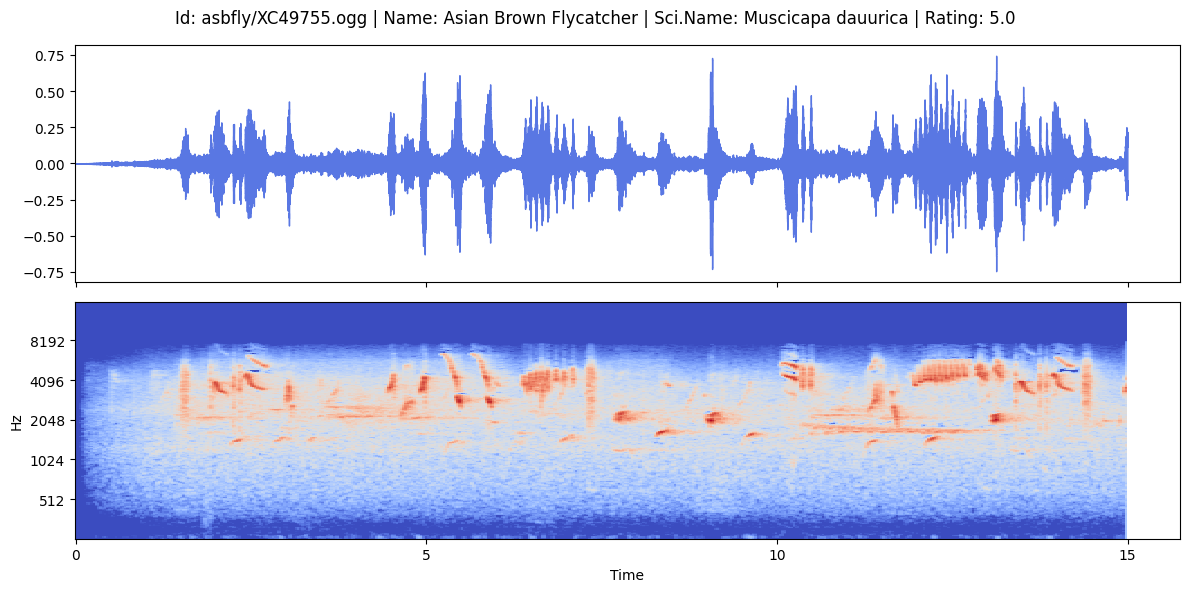

In [9]:
row = df.iloc[35]

# Display audio
display_audio(row)

## Sample 2

# Audio:


# Visualization:


/tmp/ipykernel_11457/1404149765.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


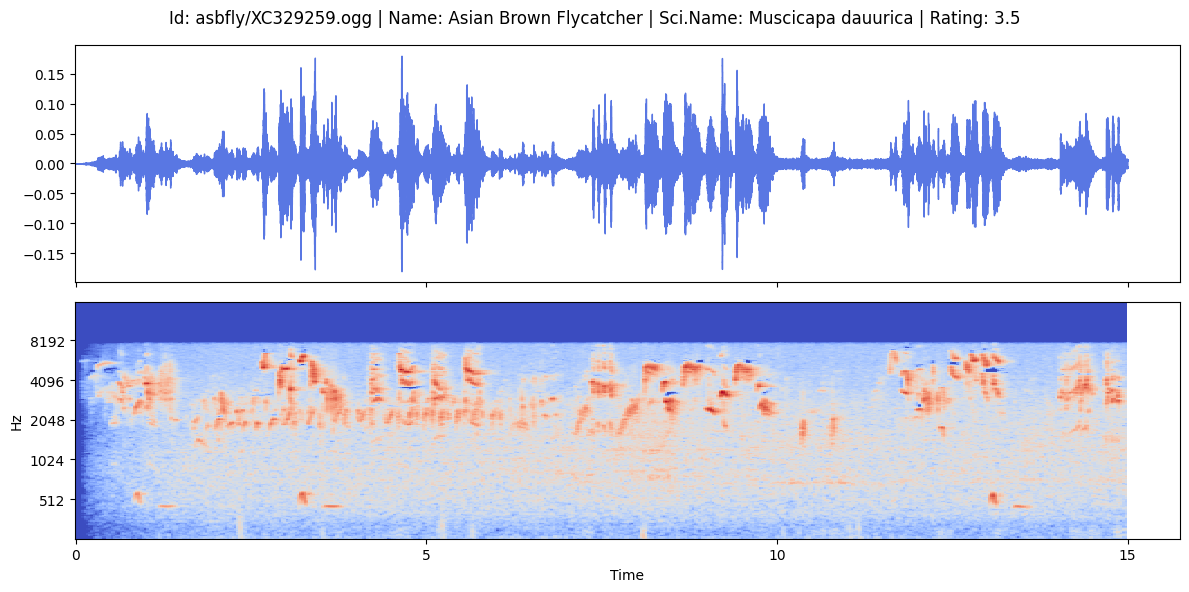

In [10]:
row = df.iloc[16]

# Display audio
display_audio(row)

## Sample 3

# Audio:


# Visualization:


/tmp/ipykernel_11457/1404149765.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


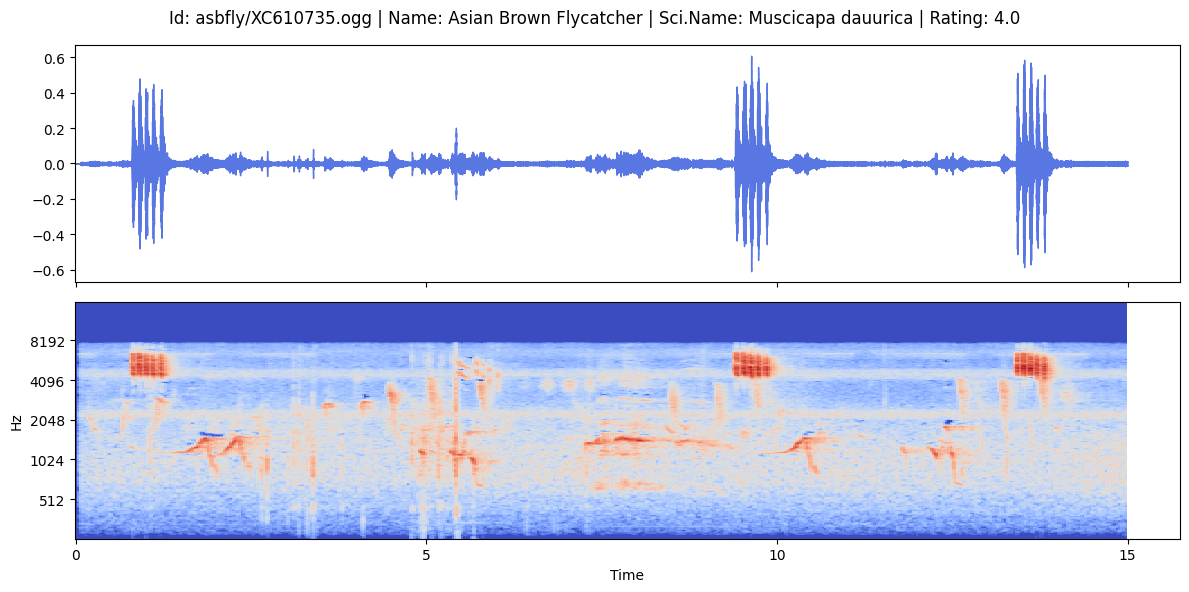

In [11]:
row = df.iloc[50]

# Display audio
display_audio(row)

# Data Split 🔪
Following code will split the data into folds using target stratification.
> **Note:** Some classess have too few samples thus not each fold contains all the classes. 

In [12]:
# Import required packages
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2)

print(f"Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

Num Train: 19567 | Num Valid: 4892


# Data Loader 🍚

## Decoders

The following code will decode the raw audio from `.ogg` file and also decode the spectrogram from the `audio` file. Additionally, we will apply Z-Score standardization and Min-Max normalization to ensure consistent inputs to the model.


In [13]:
import tensorflow_hub as hub
embedding_model = hub.load("https://tfhub.dev/google/vggish/1")

def build_decoder(with_labels=True, dim=1024):
    def get_audio(filepath):
        def _read_audio(path):
            path = path.decode('utf-8')  # Convert bytes to string
            audio, _ = librosa.load(path, sr=None, mono=True, dtype=np.float32)
            return audio

        # Use tf.numpy_function to wrap the Python function
        audio = tf.numpy_function(_read_audio, [filepath], tf.float32)
        audio.set_shape([None])  # Set the shape if known
        return audio

    def crop_or_pad(audio, target_len, pad_mode="constant"):
        audio_len = tf.shape(audio)[0]
        diff_len = abs(
            target_len - audio_len
        )  # find difference between target and audio length
        if audio_len < target_len:  # do padding if audio length is shorter
            pad1 = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            pad2 = diff_len - pad1
            audio = tf.pad(audio, paddings=[[pad1, pad2]], mode=pad_mode)
        elif audio_len > target_len:  # do cropping if audio length is larger
            idx = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            audio = audio[idx : (idx + target_len)]
        return tf.reshape(audio, [target_len])

    def get_target(target):
        target = tf.reshape(target, [1])
        target = tf.cast(tf.one_hot(target, CFG.num_classes), tf.float32)
        target = tf.reshape(target, [CFG.num_classes])
        return target

    def decode(path):
        # Load audio file
        audio = get_audio(path)
        # Crop or pad audio to keep a fixed length
        audio = crop_or_pad(audio, dim)
        
        # Use audio embedding model to get embeddings
        embeddings = embedding_model(audio)
        
        # Resize embeddings if necessary, depending on the model's output shape
        embeddings = tf.reshape(embeddings, [-1])  # Flatten embeddings to 1D
        
        return embeddings

    def decode_with_labels(path, label):
        label = get_target(label)
        return decode(path), label

    return decode_with_labels if with_labels else decode

I0000 00:00:1731341174.802303   11457 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13689 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:0f:00.0, compute capability: 8.9


## Augmenters
Following code will apply augmentations to spectrogram data. In this notebook, we will use MixUp, CutOut (TimeMasking and FreqMasking) from KerasCV.

> Note that, these augmentations will be applied to batch of spectrograms rather than single spectrograms.

## Data Pipeline
Following code builds the complete pipeline of the data flow. It uses `tf.data.Dataset` for data processing. Here are some cool features of `tf.data`,
* We can build complex input pipelines from simple, reusable pieces using`tf.data` API . For example, the pipeline for an audio model might aggregate data from files in a distributed file system, apply random transformation/augmentation to each audio/spectrogram, and merge randomly selected data into a batch for training.
* Moreover `tf.data` API provides a `tf.data.Dataset` feature that represents a sequence of components where each component comprises one or more pieces. For instance, in an audio pipeline, a component might be a single training example, with a pair of tensor pieces representing the audio and its label.

Check out this [doc](https://www.tensorflow.org/guide/data) if you want to learn more about `tf.data`.

In [14]:
def build_dataset(paths, labels=None, batch_size=32, 
                  decode_fn=None, cache=True, shuffle=2048):
    # Use a default decode function if none is provided
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None, dim=CFG.audio_len)

    # Enable data parallelism and set up data loading pipeline
    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths,) if labels is None else (paths, labels)
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    
    # Cache dataset for faster access if enabled
    if cache:
        ds = ds.cache()

    # Shuffle dataset if needed
    if shuffle:
        opt = tf.data.Options()
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)

    # Batch and prefetch dataset
    ds = ds.batch(batch_size, drop_remainder=True)
    ## try this if you wanna enable caching
    # ds = ds.repeat()
    ds = ds.prefetch(AUTO)
    
    return ds

## Build Train and Valid Dataloaders

In [15]:
# Train
train_paths = train_df.filepath.values
train_labels = train_df.target.values
train_ds = build_dataset(train_paths, train_labels, batch_size=CFG.batch_size, cache = False,
                         shuffle=True)

# Valid
valid_paths = valid_df.filepath.values
valid_labels = valid_df.target.values
valid_ds = build_dataset(valid_paths, valid_labels, batch_size=CFG.batch_size, cache = False,
                         shuffle=False)

In [16]:
# Take a single batch from the dataset to inspect the shape
for batch in train_ds.take(1):  # `ds` is the dataset created by `build_dataset`
    embeddings, labels = batch
    print("Embedding shape:", embeddings.shape)  # This will show the shape of the batch of embeddings
    print("Label shape:", labels.shape)


Embedding shape: (32, 1920)
Label shape: (32, 182)


2024-11-11 11:06:32.841853: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Visualization 🔭
To ensure our pipeline is generating **spectrogram** and its associate **label** correctly, we'll check some samples from a batch.

# 🤖 Modeling

Building a model for an audio recognition task with spectrograms as input is quite straightforward, as it is very similar to image classification. This is because the shape of spectrogram data is very similar to image data. In this notebook, to perform the audio recognition task, we will utilize the `EfficientNetV2` ImageNet-pretrained model as the backbone. Even though this backbone is pretrained with ImageNet data instead of spectrogram data, we can leverage transfer learning to adapt it to our spectrogram-based task.

> Note that we can train our model on any duration audio file (here we are using `10 seconds`), but we will always infer on `5-second` audio files (as per competition rules). To facilitate this, we have set the model input shape to `(None, None, 3)`, which will allow us to have variable-length input during training and inference.


In case you are wondering, **Why not train and infer on both `5-second`?** In the train data, we have long audio files, but we are not sure which part of the audio contains the labeled bird's song. In other words, this is weakly labeled. To ensure the provided label is accurately suited to the audio, we are using a larger audio size than `5 seconds`. You are welcome to try out different audio lengths for training.


In [17]:
from tensorflow.keras import layers

# Define the embedding dimension and number of classes
embedding_dim = embeddings.shape[1]  # Based on your embedding shape
num_classes = labels.shape[1]     # Based on your label shape

# Create an input layer for the embeddings
inp = layers.Input(shape=(embedding_dim,), name="embedding_input")

# Dense layers for processing the embedding
x = layers.Dense(1024, activation="relu")(inp)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(512, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

# Output layer for classification
out = layers.Dense(num_classes, activation="softmax", name="classifier")(x)

# Build the model
model = keras.models.Model(inputs=inp, outputs=out)

# Compile model with optimizer, loss, and metrics
model.compile(
    optimizer="adam",
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
    metrics=[keras.metrics.AUC(name="auc")]
)

# Display the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_input (InputLayer)    │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,967,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 182)            │        46,774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,677,174 (10.21 MB)

 Trainable params: 2,673,590 (10.20 MB)

 Non-trainable params: 3,584 (14.00 KB)

# LR Schedule ⚓
* Learning Rate scheduler for transfer learning. 
* The learning rate starts from `lr_start`, then decreases to a`lr_min` using different methods namely,
    * **step**: Reduce lr step wise like stair.
    * **cos**: Follow Cosine graph to reduce lr.
    * **exp**: Reduce lr exponentially.

In [18]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 8e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

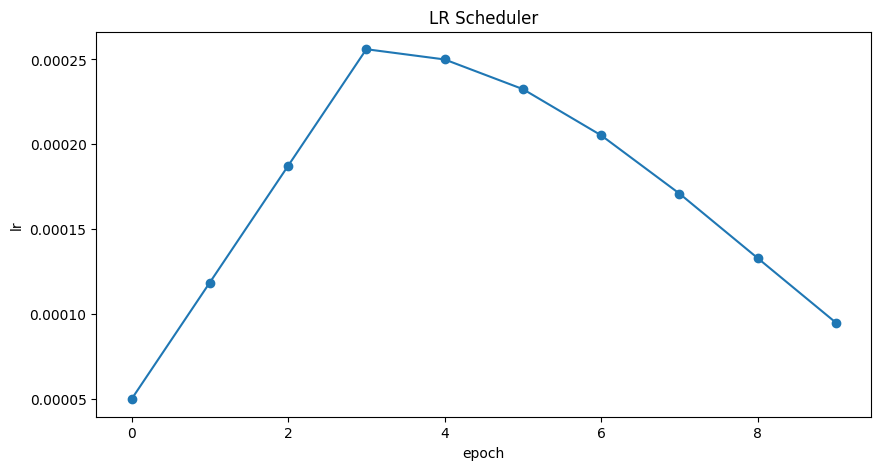

In [19]:
lr_cb = get_lr_callback(CFG.batch_size, plot=True)

# Model Checkpoint 💾

In [20]:
ckpt_cb = keras.callbacks.ModelCheckpoint("best_model.weights.h5",
                                         monitor='val_auc',
                                         save_best_only=True,
                                         save_weights_only=True,
                                         mode='max')

# Training 🚄

In [21]:
history = model.fit(
    train_ds, 
    validation_data=valid_ds, 
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb], 
    verbose=1
)

Epoch 1/10


I0000 00:00:1731341200.554018   11585 service.cc:148] XLA service 0x7fe2b40101b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731341200.554367   11585 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-11-11 11:06:40.599412: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731341200.753917   11585 cuda_dnn.cc:529] Loaded cuDNN version 90501
2024-11-11 11:06:41.822610: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1591', 28 bytes spill stores, 28 bytes spill loads

2024-11-11 11:06:41.995675: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1589', 216 b

  1/611 ━━━━━━━━━━━━━━━━━━━━ 2:36:21 15s/step - auc: 0.4585 - loss: 6.1218

I0000 00:00:1731341208.637356   11585 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


611/611 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - auc: 0.5392 - loss: 5.7656

2024-11-11 12:22:53.247417: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node Func/StatefulPartitionedCall/input_control_node/_0/_7}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2024-11-11 12:22:53.248466: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6958054130412753803
2024-11-11 12:22:53.248523: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6300113496187397539
2024-11-11 12:22:53.248540: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9021303359649209661
2024-11-11 12:22:53.248554: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14012591152715169561
2024-11-11 12:22:53.248565: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key has

611/611 ━━━━━━━━━━━━━━━━━━━━ 4581s 7s/step - auc: 0.5393 - loss: 5.7653 - val_auc: 0.6845 - val_loss: 4.8237 - learning_rate: 5.0000e-05
Epoch 2/10
611/611 ━━━━━━━━━━━━━━━━━━━━ 4804s 8s/step - auc: 0.6684 - loss: 5.0473 - val_auc: 0.7872 - val_loss: 4.3284 - learning_rate: 1.1867e-04
Epoch 3/10


2024-11-11 13:42:57.315190: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/vggish/conv2/Conv2D/ReadVariableOp/_14}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2024-11-11 13:42:57.315386: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 10437890806637898720


611/611 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - auc: 0.7647 - loss: 4.4910

2024-11-11 15:06:17.718532: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6300113496187397539


611/611 ━━━━━━━━━━━━━━━━━━━━ 5001s 8s/step - auc: 0.7647 - loss: 4.4909 - val_auc: 0.8301 - val_loss: 4.0426 - learning_rate: 1.8733e-04
Epoch 4/10
611/611 ━━━━━━━━━━━━━━━━━━━━ 5063s 8s/step - auc: 0.8113 - loss: 4.1728 - val_auc: 0.8425 - val_loss: 3.9183 - learning_rate: 2.5600e-04
Epoch 5/10
611/611 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - auc: 0.8375 - loss: 3.9637

2024-11-11 17:52:50.667951: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 9021303359649209661


611/611 ━━━━━━━━━━━━━━━━━━━━ 4979s 8s/step - auc: 0.8375 - loss: 3.9636 - val_auc: 0.8446 - val_loss: 3.9099 - learning_rate: 2.4998e-04
Epoch 6/10
611/611 ━━━━━━━━━━━━━━━━━━━━ 5130s 8s/step - auc: 0.8557 - loss: 3.8387 - val_auc: 0.8552 - val_loss: 3.7820 - learning_rate: 2.3251e-04
Epoch 7/10
611/611 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - auc: 0.8659 - loss: 3.7124

2024-11-11 20:42:44.822378: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/vggish/fc1/fc1_2/BiasAdd/ReadVariableOp/_40}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2024-11-11 20:42:44.822592: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14584512211669266932
2024-11-11 20:42:44.822615: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6958054130412753803
2024-11-11 20:42:44.822628: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16495260606473720450
2024-11-11 20:42:44.822634: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9021303359649209661
2024-11-11 20:42:44.822663: I tensorflow/core/framework/local_r

611/611 ━━━━━━━━━━━━━━━━━━━━ 5015s 8s/step - auc: 0.8659 - loss: 3.7124 - val_auc: 0.8692 - val_loss: 3.6362 - learning_rate: 2.0530e-04
Epoch 8/10
611/611 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - auc: 0.8733 - loss: 3.6231

2024-11-11 22:05:52.999567: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6958054130412753803
2024-11-11 22:05:52.999830: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9021303359649209661
2024-11-11 22:05:52.999875: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6300113496187397539
2024-11-11 22:05:52.999889: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14012591152715169561
2024-11-11 22:05:52.999908: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17274598857737995514
2024-11-11 22:05:52.999927: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2489055083952694910
2024-11-11 22:05:52.999940: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

611/611 ━━━━━━━━━━━━━━━━━━━━ 4988s 8s/step - auc: 0.8733 - loss: 3.6231 - val_auc: 0.8628 - val_loss: 3.6987 - learning_rate: 1.7101e-04
Epoch 9/10
611/611 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - auc: 0.8805 - loss: 3.5578

2024-11-11 23:30:11.674549: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 14298684345113241320


611/611 ━━━━━━━━━━━━━━━━━━━━ 5059s 8s/step - auc: 0.8805 - loss: 3.5577 - val_auc: 0.8736 - val_loss: 3.5911 - learning_rate: 1.3300e-04
Epoch 10/10
611/611 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - auc: 0.8877 - loss: 3.4710

2024-11-12 00:53:07.484388: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 13746280401072113520


611/611 ━━━━━━━━━━━━━━━━━━━━ 4975s 8s/step - auc: 0.8877 - loss: 3.4710 - val_auc: 0.8787 - val_loss: 3.5205 - learning_rate: 9.4991e-05


## Result Summary

In [22]:
best_epoch = np.argmax(history.history["val_auc"])
best_score = history.history["val_auc"][best_epoch]
print('>>> Best AUC: ', best_score)
print('>>> Best Epoch: ', best_epoch+1)

>>> Best AUC:  0.8787025213241577
>>> Best Epoch:  10


# Reference ✍️
* [BirdCLEF23: Pretraining is All you Need [Train]](https://www.kaggle.com/code/awsaf49/birdclef23-pretraining-is-all-you-need-train) by @awsaf49
* [RANZCR: EfficientNet TPU Training](https://www.kaggle.com/code/xhlulu/ranzcr-efficientnet-tpu-training) by @xhlulu
* [Triple Stratified KFold with TFRecords](https://www.kaggle.com/code/cdeotte/triple-stratified-kfold-with-tfrecords) by @cdeotte